<a href="https://colab.research.google.com/github/shahriariit/phishingTL/blob/main/Refined_TL_using_5000_unlabel_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import warnings
warnings.filterwarnings('ignore')


In [ ]:
url = 'https://media.githubusercontent.com/media/shahriariit/opendataset/master/PhiUSIIL_phishing.csv'
data = pd.read_csv(url)
data.head()

,URLLength,DomainLength,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,31,24,231,100.0,1.000000,0.522907,0.061933,3,1,0,...,0,0,1,34,20,28,119,0,124,1
1,23,16,254,100.0,0.666667,0.032650,0.050207,2,1,0,...,0,0,1,50,9,8,39,0,217,1
2,29,22,647,100.0,0.866667,0.028555,0.064129,2,2,0,...,0,0,1,10,2,7,42,2,5,1
3,26,19,231,100.0,1.000000,0.522907,0.057606,3,1,0,...,1,1,1,3,27,15,22,1,31,1
4,33,26,503,100.0,1.000000,0.079963,0.059441,3,1,0,...,1,0,1,244,15,34,72,1,85,1


In [ ]:
data.shape

(235795, 49)

In [ ]:
def datapartition(data):
    M = data.drop('label', axis=1)
    n = data['label']
    x_train, x_test, y_train, y_test = train_test_split(M, n, test_size=0.2, random_state=42)
    return x_train, x_test, y_train, y_test

In [ ]:
def data_split_simulation(df, num_unlabeled):
    M = df.drop('label', axis=1)
    n = df['label']
    unlabeled_indices= np.random.choice(len(M), num_unlabeled, replace=False)
    n.iloc[unlabeled_indices] = -1
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(M, n, test_size=num_unlabeled, random_state=42, stratify=n)
    return X_labeled, X_unlabeled, y_labeled, y_unlabeled

In [ ]:
def correlation_analysis(threshold):
    # Find pairs of highly correlated features
    high_corr_var = np.where((correlation_matrix >= threshold) | (correlation_matrix <= -threshold))
    high_corr_pairs = [(correlation_matrix.columns[x], correlation_matrix.columns[y])
                   for x, y in zip(*high_corr_var) if x != y and x < y]

     # Display the highly correlated pairs
    for pair in high_corr_pairs:
        print(pair)

In [ ]:
def top_features_from_kbest(data):
  FIT_FEATURES = SelectKBest(score_func=f_classif)
  M = data.drop('label', axis=1)
  n = data['label']
  FIT_FEATURES.fit(M,n)
  score_col=pd.DataFrame(FIT_FEATURES.scores_, columns=['score_value'])
  name_col=pd.DataFrame(M.columns)
  top_features=pd.concat([name_col, score_col], axis=1)
  top_features.columns=['feature_name', 'score_value']
  top_features_sorted = top_features.sort_values('score_value', ascending=False)
  print(top_features_sorted)

In [ ]:
def remove_outliers_iqr(df, k=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    return df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

In [ ]:
def z_score_tranformation(df_train, df_test):
  scaler = StandardScaler()
  df_train_scaled = scaler.fit_transform(df_train)
  df_test_scaled = scaler.transform(df_test)
  return df_train_scaled, df_test_scaled

In [ ]:
def min_max_tranformation(df_train, df_test):
  scaler = MinMaxScaler()
  df_train_scaled = scaler.fit_transform(df_train)
  df_test_scaled = scaler.transform(df_test)
  return df_train_scaled, df_test_scaled

In [ ]:
def log_tranformation(df_train, df_test):
  df_train_log = np.log1p(df_train)
  df_test_log = np.log1p(df_test)
  return df_train_log, df_test_log

In [ ]:
def classification_metrics(X_labeled, X_unlabeled, y_labeled, y_unlabeled):
    models = {
       "KNeighbors": KNeighborsClassifier(),
       "Random Forest": RandomForestClassifier(random_state=42),
       "Gradient Boosting": GradientBoostingClassifier(random_state=42),
       "Logistic Regression": LogisticRegression(),
       "Decision Tree": DecisionTreeClassifier(random_state=42),
       "Naive Bayes": GaussianNB(),
       "AdaBoost": AdaBoostClassifier(random_state=42),
       "Linear SVC": LinearSVC(random_state=42, max_iter=5000),
    }

    for name, model in models.items():
       print(f"--- {name} ---")
       model.fit(X_labeled, y_labeled)
       y_pred = model.predict(X_unlabeled)

       accuracy = accuracy_score(y_unlabeled, y_pred)
       precision = precision_score(y_unlabeled, y_pred, average='weighted')
       recall = recall_score(y_unlabeled, y_pred, average='weighted')
       f_measure = f1_score(y_unlabeled, y_pred, average='weighted')

       print(f"Accuracy: {accuracy:.4f}")
       print(f"Precision: {precision:.4f}")
       print(f"Recall: {recall:.4f}")
       print(f"F-Measure: {f_measure:.4f}\n")

In [ ]:
data1=data.copy()
data2=data.copy()

Correlation based Feature Selection

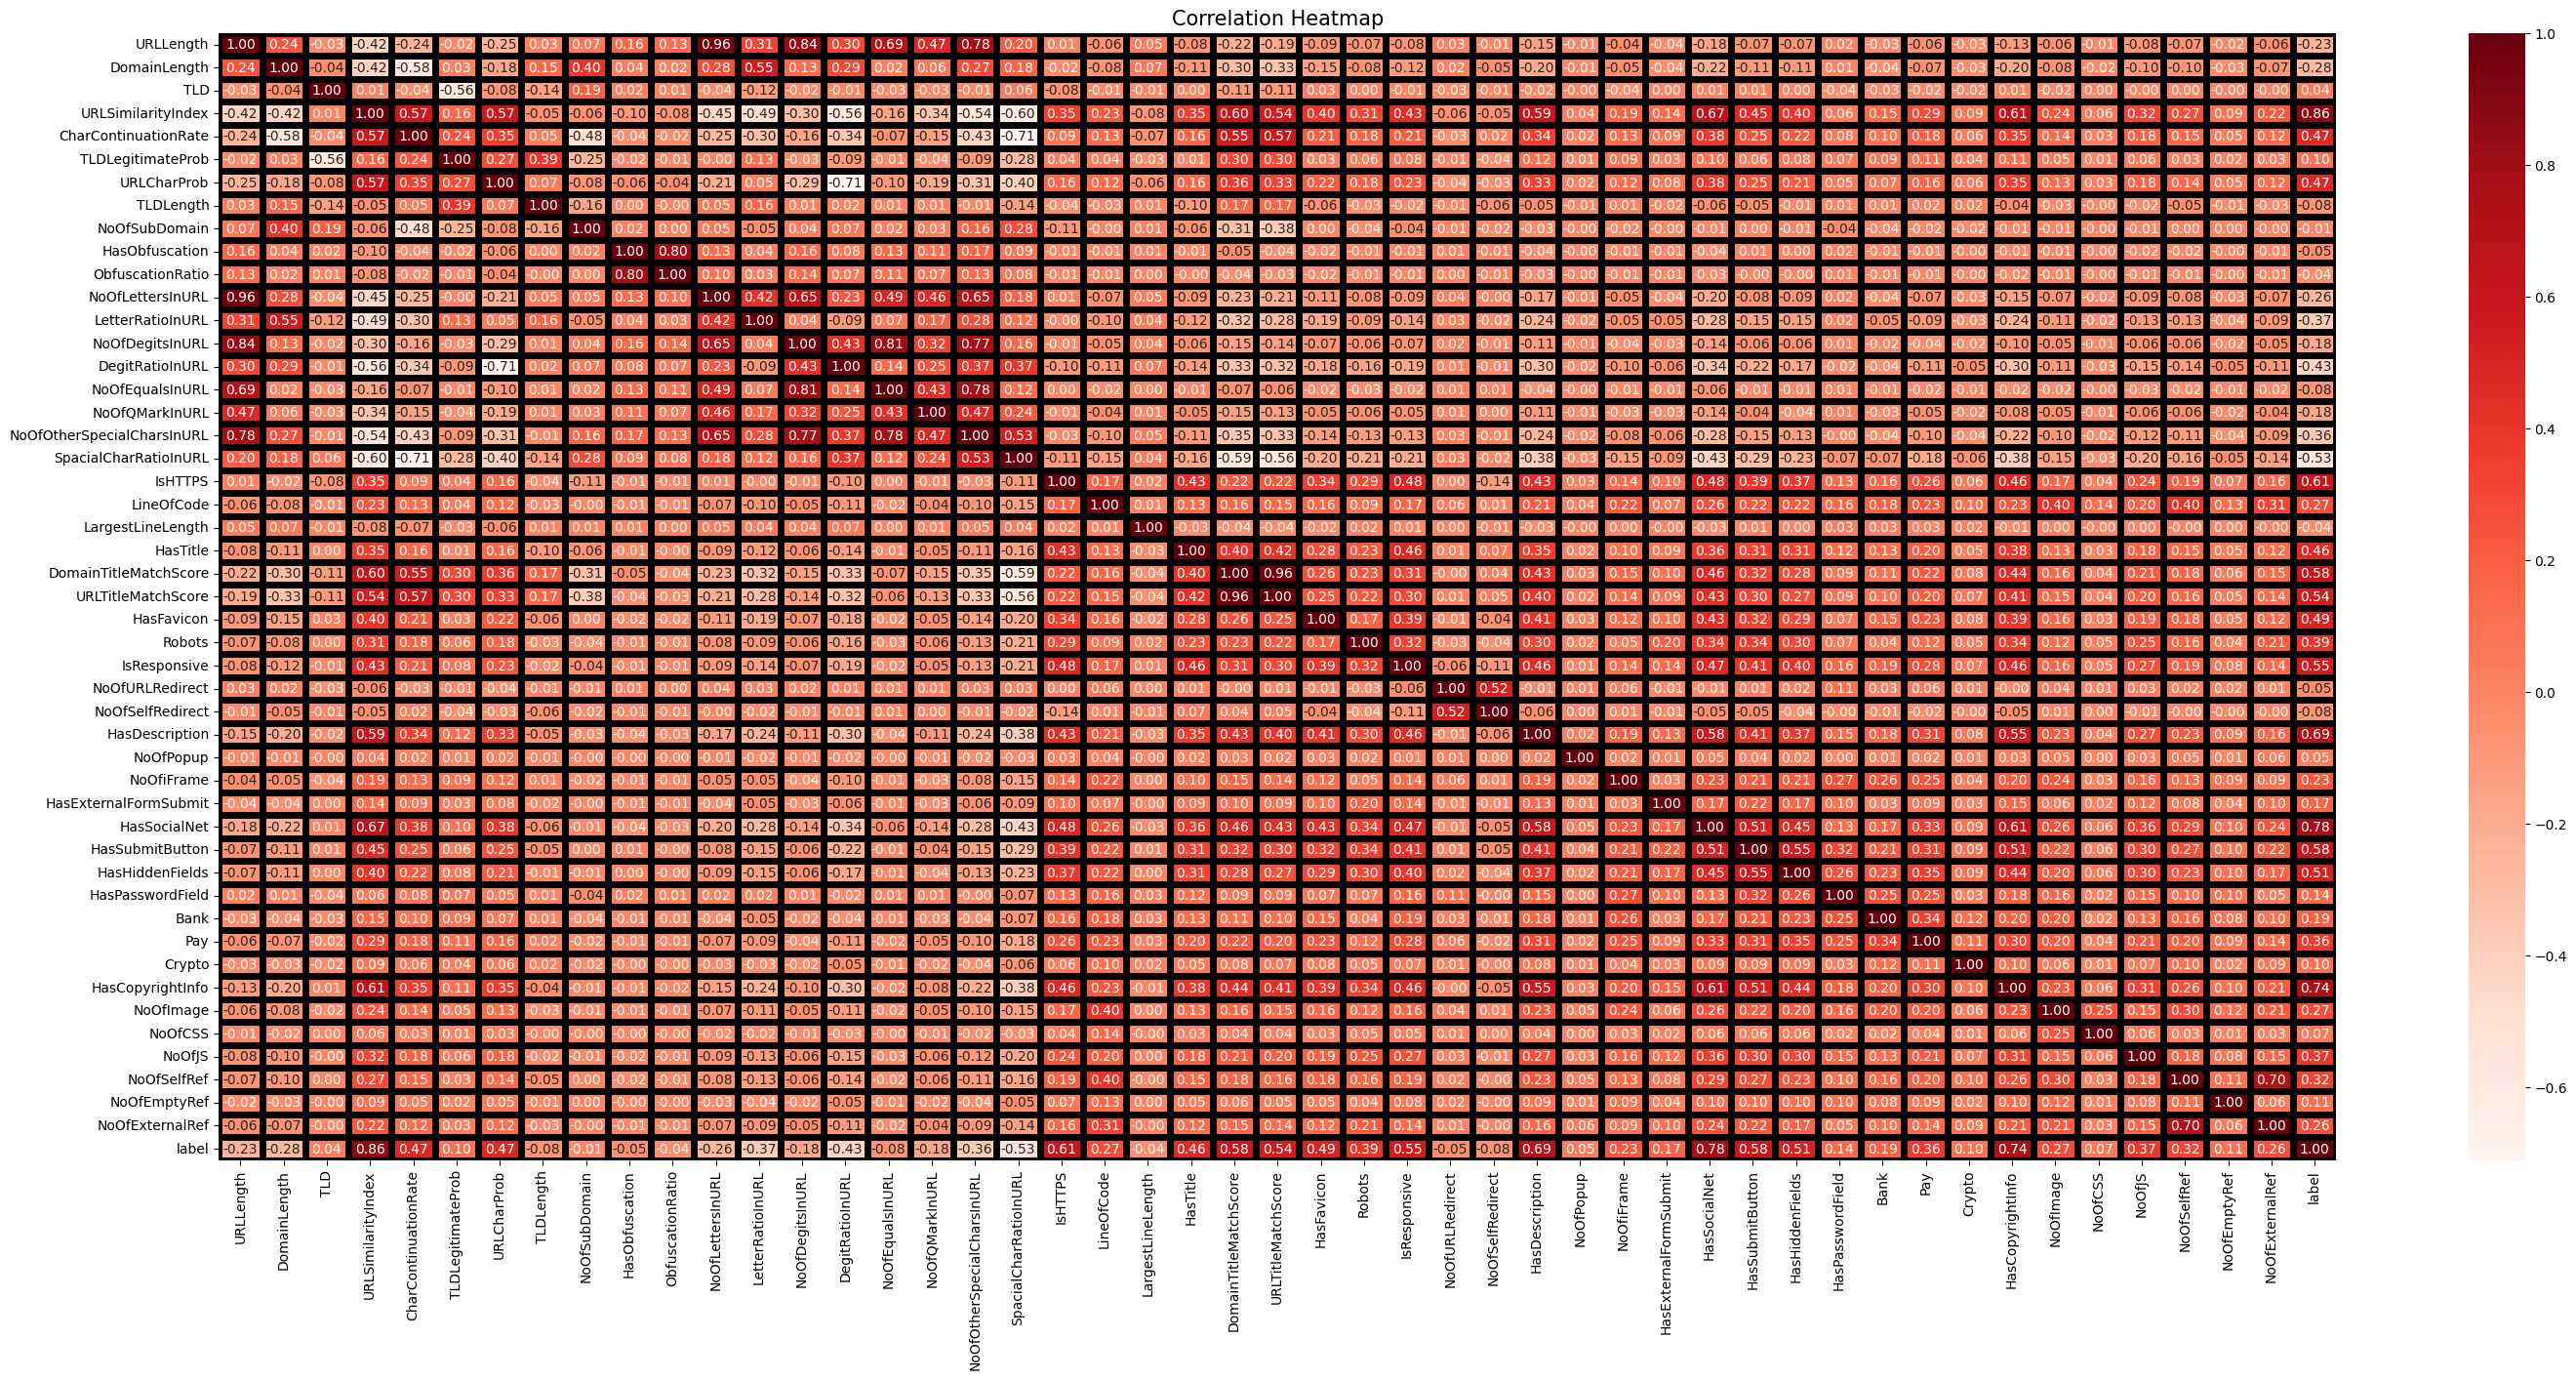

In [ ]:
correlation_matrix = data.corr()

plt.figure(figsize=(35,15))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', fmt='.2f', linecolor='k', linewidths=5)
plt.title('Correlation Heatmap', fontsize=15)
plt.show()

In [ ]:
correlation_analysis(0.8)

('URLLength', 'NoOfLettersInURL')
('URLLength', 'NoOfDegitsInURL')
('URLSimilarityIndex', 'label')
('NoOfDegitsInURL', 'NoOfEqualsInURL')
('DomainTitleMatchScore', 'URLTitleMatchScore')


In [ ]:
data1.drop(columns=['URLLength', 'NoOfLettersInURL','NoOfDegitsInURL', 'NoOfEqualsInURL', 'URLTitleMatchScore'], axis=1, inplace=True)
data1.head()

,DomainLength,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,ObfuscationRatio,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,24,231,100.0,1.000000,0.522907,0.061933,3,1,0,0.0,...,0,0,1,34,20,28,119,0,124,1
1,16,254,100.0,0.666667,0.032650,0.050207,2,1,0,0.0,...,0,0,1,50,9,8,39,0,217,1
2,22,647,100.0,0.866667,0.028555,0.064129,2,2,0,0.0,...,0,0,1,10,2,7,42,2,5,1
3,19,231,100.0,1.000000,0.522907,0.057606,3,1,0,0.0,...,1,1,1,3,27,15,22,1,31,1
4,26,503,100.0,1.000000,0.079963,0.059441,3,1,0,0.0,...,1,0,1,244,15,34,72,1,85,1


In [ ]:
data1.shape

(235795, 44)

SelectKBest based Feature Selection

In [ ]:
top_features_from_kbest(data)

                  feature_name    score_value
3           URLSimilarityIndex  671857.021354
34                HasSocialNet  376744.060221
41            HasCopyrightInfo  291213.405607
30              HasDescription  214554.534151
19                     IsHTTPS  139101.470625
23       DomainTitleMatchScore  122616.776204
35             HasSubmitButton  118640.503918
27                IsResponsive  101521.680953
24          URLTitleMatchScore   96765.322906
18       SpacialCharRatioInURL   93831.344742
36             HasHiddenFields   81897.941275
25                  HasFavicon   75999.486238
6                  URLCharProb   66763.176874
4         CharContinuationRate   66032.204782
22                    HasTitle   63188.852835
14             DegitRatioInURL   54111.119075
26                      Robots   42971.692064
44                      NoOfJS   38226.328013
12            LetterRatioInURL   36886.020298
39                         Pay   35052.121795
17  NoOfOtherSpecialCharsInURL   3

In [ ]:
data2.drop(columns=['LineOfCode', 'NoOfOtherSpecialCharsInURL','Pay', 'LetterRatioInURL','NoOfJS','NoOfExternalRef' , 'NoOfiFrame',  'NoOfQMarkInURL' , 'HasExternalFormSubmit',  'HasPasswordField', 'HasHiddenFields', 'NoOfEmptyRef', 'Crypto', 'TLDLegitimateProb','TLDLength', 'NoOfSelfRedirect','NoOfCSS' ,'HasObfuscation', 'NoOfPopup' , 'NoOfURLRedirect', 'ObfuscationRatio','LargestLineLength', 'TLD', 'NoOfSubDomain'], axis=1, inplace=True)
data2.head()

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,URLCharProb,NoOfLettersInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,SpacialCharRatioInURL,...,Robots,IsResponsive,HasDescription,HasSocialNet,HasSubmitButton,Bank,HasCopyrightInfo,NoOfImage,NoOfSelfRef,label
0,31,24,100.0,1.000000,0.061933,18,0,0.0,0,0.032,...,1,1,0,0,1,1,1,34,119,1
1,23,16,100.0,0.666667,0.050207,9,0,0.0,0,0.087,...,1,0,0,1,1,0,1,50,39,1
2,29,22,100.0,0.866667,0.064129,15,0,0.0,0,0.069,...,1,1,1,0,1,0,1,10,42,1
3,26,19,100.0,1.000000,0.057606,13,0,0.0,0,0.038,...,1,1,0,1,1,0,1,3,22,1
4,33,26,100.0,1.000000,0.059441,20,0,0.0,0,0.030,...,1,1,1,1,1,1,1,244,72,1


In [ ]:
data2.shape

(235795, 25)

Outlier Detection

In [ ]:
# Remove outliers
data1_no_outliers = remove_outliers_iqr(data1)

# Display the result
print("Dataset1 shape:", data1.shape)
print("Dataset1 shape after removing outliers using IQR method:", data1_no_outliers.shape)

Dataset1 shape: (235795, 44)
Dataset1 shape after removing outliers using IQR method: (26872, 44)


In [ ]:
# Remove outliers
data2_no_outliers = remove_outliers_iqr(data2)

# Display the result
print("Dataset2 shape:", data2.shape)
print("Dataset2 shape after removing outliers using IQR method:", data2_no_outliers.shape)

Dataset2 shape: (235795, 25)
Dataset2 shape after removing outliers using IQR method: (98462, 25)


Feature Transformation

In [ ]:
X_train, X_test, y_train, y_test = datapartition(data)
X_train_data1, X_test_data1, y_train_data1, y_test_data1 = datapartition(data1_no_outliers)
X_train_data2, X_test_data2, y_train_data2, y_test_data2 = datapartition(data2_no_outliers)

In [ ]:
classification_metrics(X_train, X_test, y_train, y_test)

--- KNeighbors ---
Accuracy: 0.9961
Precision: 0.9961
Recall: 0.9961
F-Measure: 0.9961

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9969
Precision: 0.9969
Recall: 0.9969
F-Measure: 0.9969

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 0.9818
Precision: 0.9825
Recall: 0.9818
F-Measure: 0.9818

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9968
Precision: 0.9968
Recall: 0.9968
F-Measure: 0.9968



In [ ]:
classification_metrics(X_train_data1, X_test_data1, y_train_data1, y_test_data1)

--- KNeighbors ---
Accuracy: 0.9967
Precision: 0.9966
Recall: 0.9967
F-Measure: 0.9966

--- Random Forest ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9985
Precision: 0.9985
Recall: 0.9985
F-Measure: 0.9985

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9983
Precision: 0.9983
Recall: 0.9983
F-Measure: 0.9983



In [ ]:
classification_metrics(X_train_data2, X_test_data2, y_train_data2, y_test_data2)

--- KNeighbors ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- Random Forest ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Gradient Boosting ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Logistic Regression ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- Decision Tree ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Naive Bayes ---
Accuracy: 0.9995
Precision: 0.9995
Recall: 0.9995
F-Measure: 0.9995

--- AdaBoost ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Linear SVC ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997



In [ ]:
X_train_scaled, X_test_scaled =z_score_tranformation(X_train, X_test)
X_train_scaled_data1, X_test_scaled_data1 =z_score_tranformation(X_train_data1, X_test_data1)
X_train_scaled_data2, X_test_scaled_data2 =z_score_tranformation(X_train_data2, X_test_data2)

In [ ]:
classification_metrics(X_train_scaled, X_test_scaled, y_train, y_test)

--- KNeighbors ---
Accuracy: 0.9986
Precision: 0.9986
Recall: 0.9986
F-Measure: 0.9986

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000



In [ ]:
classification_metrics(X_train_scaled_data1, X_test_scaled_data1, y_train_data1, y_test_data1)

--- KNeighbors ---
Accuracy: 0.9994
Precision: 0.9994
Recall: 0.9994
F-Measure: 0.9994

--- Random Forest ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000



In [ ]:
classification_metrics(X_train_scaled_data2, X_test_scaled_data2, y_train_data2, y_test_data2)

--- KNeighbors ---
Accuracy: 0.9992
Precision: 0.9992
Recall: 0.9992
F-Measure: 0.9992

--- Random Forest ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Gradient Boosting ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Logistic Regression ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- Decision Tree ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Naive Bayes ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- AdaBoost ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Linear SVC ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998



In [ ]:
X_train_mxscaled, X_test_mxscaled =min_max_tranformation(X_train, X_test)
X_train_mxscaled_data1, X_test_mxscaled_data1 =min_max_tranformation(X_train_data1, X_test_data1)
X_train_mxscaled_data2, X_test_mxscaled_data2 =min_max_tranformation(X_train_data2, X_test_data2)

In [ ]:
classification_metrics(X_train_mxscaled, X_test_mxscaled, y_train, y_test)

--- KNeighbors ---
Accuracy: 0.9963
Precision: 0.9963
Recall: 0.9963
F-Measure: 0.9963

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999



In [ ]:
classification_metrics(X_train_mxscaled_data1, X_test_mxscaled_data1, y_train_data1, y_test_data1)

--- KNeighbors ---
Accuracy: 0.9987
Precision: 0.9987
Recall: 0.9987
F-Measure: 0.9987

--- Random Forest ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000



In [ ]:
classification_metrics(X_train_mxscaled_data2, X_test_mxscaled_data2, y_train_data2, y_test_data2)

--- KNeighbors ---
Accuracy: 0.9979
Precision: 0.9979
Recall: 0.9979
F-Measure: 0.9979

--- Random Forest ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Gradient Boosting ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Logistic Regression ---
Accuracy: 0.9994
Precision: 0.9994
Recall: 0.9994
F-Measure: 0.9994

--- Decision Tree ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Naive Bayes ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- AdaBoost ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Linear SVC ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997



In [ ]:
X_train_logscaled, X_test_logscaled = log_tranformation(X_train, X_test)
X_train_logscaled_data1, X_test_logscaled_data1 = log_tranformation(X_train_data1, X_test_data1)
X_train_logscaled_data2, X_test_logscaled_data2 = log_tranformation(X_train_data2, X_test_data2)

In [ ]:
classification_metrics(X_train_logscaled, X_test_logscaled, y_train, y_test)

--- KNeighbors ---
Accuracy: 0.9990
Precision: 0.9990
Recall: 0.9990
F-Measure: 0.9990

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 0.9991
Precision: 0.9991
Recall: 0.9991
F-Measure: 0.9991

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999



Simulation

In [ ]:
X_train_tl, X_test_tl, y_train_tl, y_test_tl = data_split_simulation(data,5000)
X_train_tl_data1, X_test_tl_data1, y_train_tl_data1, y_test_tl_data1 = data_split_simulation(data1_no_outliers,5000)
X_train_tl_data2, X_test_tl_data2, y_train_tl_data2, y_test_tl_data2 = data_split_simulation(data2_no_outliers,5000)

In [ ]:
classification_metrics(X_train_tl, X_test_tl, y_train_tl, y_test_tl)

--- KNeighbors ---
Accuracy: 0.9316
Precision: 0.8757
Recall: 0.9316
F-Measure: 0.9028

--- Random Forest ---
Accuracy: 0.9344
Precision: 0.8825
Recall: 0.9344
F-Measure: 0.9062

--- Gradient Boosting ---
Accuracy: 0.9374
Precision: 0.8791
Recall: 0.9374
F-Measure: 0.9073

--- Logistic Regression ---
Accuracy: 0.9130
Precision: 0.8597
Recall: 0.9130
F-Measure: 0.8855

--- Decision Tree ---
Accuracy: 0.8684
Precision: 0.8834
Recall: 0.8684
F-Measure: 0.8757

--- Naive Bayes ---
Accuracy: 0.9130
Precision: 0.8681
Recall: 0.9130
F-Measure: 0.8890

--- AdaBoost ---
Accuracy: 0.9296
Precision: 0.8818
Recall: 0.9296
F-Measure: 0.9041

--- Linear SVC ---
Accuracy: 0.9358
Precision: 0.8779
Recall: 0.9358
F-Measure: 0.9059



In [ ]:
classification_metrics(X_train_tl_data1, X_test_tl_data1, y_train_tl_data1, y_test_tl_data1)

--- KNeighbors ---
Accuracy: 0.7816
Precision: 0.6972
Recall: 0.7816
F-Measure: 0.7274

--- Random Forest ---
Accuracy: 0.8090
Precision: 0.6959
Recall: 0.8090
F-Measure: 0.7305

--- Gradient Boosting ---
Accuracy: 0.8130
Precision: 0.6624
Recall: 0.8130
F-Measure: 0.7300

--- Logistic Regression ---
Accuracy: 0.7992
Precision: 0.6839
Recall: 0.7992
F-Measure: 0.7198

--- Decision Tree ---
Accuracy: 0.6826
Precision: 0.6973
Recall: 0.6826
F-Measure: 0.6897

--- Naive Bayes ---
Accuracy: 0.8064
Precision: 0.7038
Recall: 0.8064
F-Measure: 0.7315

--- AdaBoost ---
Accuracy: 0.7286
Precision: 0.7035
Recall: 0.7286
F-Measure: 0.7147

--- Linear SVC ---
Accuracy: 0.8128
Precision: 0.6616
Recall: 0.8128
F-Measure: 0.7295



In [ ]:
classification_metrics(X_train_tl_data2, X_test_tl_data2, y_train_tl_data2, y_test_tl_data2)

--- KNeighbors ---
Accuracy: 0.9480
Precision: 0.9074
Recall: 0.9480
F-Measure: 0.9242

--- Random Forest ---
Accuracy: 0.9492
Precision: 0.9266
Recall: 0.9492
F-Measure: 0.9249

--- Gradient Boosting ---
Accuracy: 0.9488
Precision: 0.9006
Recall: 0.9488
F-Measure: 0.9241

--- Logistic Regression ---
Accuracy: 0.9482
Precision: 0.9008
Recall: 0.9482
F-Measure: 0.9239

--- Decision Tree ---
Accuracy: 0.8882
Precision: 0.9032
Recall: 0.8882
F-Measure: 0.8956

--- Naive Bayes ---
Accuracy: 0.9458
Precision: 0.9036
Recall: 0.9458
F-Measure: 0.9229

--- AdaBoost ---
Accuracy: 0.9454
Precision: 0.9006
Recall: 0.9454
F-Measure: 0.9224

--- Linear SVC ---
Accuracy: 0.9490
Precision: 0.9008
Recall: 0.9490
F-Measure: 0.9243



In [ ]:
X_train_tl_scaled, X_test_tl_scaled =z_score_tranformation(X_train_tl, X_test_tl)
X_train_tl_scaled_data1, X_test_tl_scaled_data1 =z_score_tranformation(X_train_tl_data1, X_test_tl_data1)
X_train_tl_scaled_data2, X_test_tl_scaled_data2 =z_score_tranformation(X_train_tl_data2, X_test_tl_data2)

In [ ]:
classification_metrics(X_train_tl_scaled_data1, X_test_tl_scaled_data1, y_train_tl_data1, y_test_tl_data1)

--- KNeighbors ---
Accuracy: 0.7822
Precision: 0.6966
Recall: 0.7822
F-Measure: 0.7276

--- Random Forest ---
Accuracy: 0.8090
Precision: 0.6959
Recall: 0.8090
F-Measure: 0.7305

--- Gradient Boosting ---
Accuracy: 0.8130
Precision: 0.6624
Recall: 0.8130
F-Measure: 0.7300

--- Logistic Regression ---
Accuracy: 0.8124
Precision: 0.7035
Recall: 0.8124
F-Measure: 0.7303

--- Decision Tree ---
Accuracy: 0.6820
Precision: 0.6974
Recall: 0.6820
F-Measure: 0.6894

--- Naive Bayes ---
Accuracy: 0.8056
Precision: 0.7060
Recall: 0.8056
F-Measure: 0.7321

--- AdaBoost ---
Accuracy: 0.7286
Precision: 0.7035
Recall: 0.7286
F-Measure: 0.7147

--- Linear SVC ---
Accuracy: 0.8134
Precision: 0.6621
Recall: 0.8134
F-Measure: 0.7300



In [ ]:
X_train_tl_mxscaled, X_test_tl_mxscaled =min_max_tranformation(X_train_tl, X_test_tl)
X_train_tl_mxscaled_data1, X_test_mxscaled_data1 =min_max_tranformation(X_train_tl_data1, X_test_tl_data1)
X_train_tl_mxscaled_data2, X_test_mxscaled_data2 =min_max_tranformation(X_train_tl_data2, X_test_tl_data2)

In [ ]:
X_train_tl_logscaled, X_test_tl_logscaled = log_tranformation(X_train_tl, X_test_tl)
X_train_tl_logscaled_data1, X_test_tl_logscaled_data1 = log_tranformation(X_train_tl_data1, X_test_tl_data1)
X_train_tl_logscaled_data2, X_test_tl_logscaled_data2 = log_tranformation(X_train_tl_data2, X_test_tl_data2)